<a href="https://colab.research.google.com/github/lucas-fpaiva/tcc_pes/blob/main/piloto/notebookraul_Piloto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entendendo o problema de predição de saude da aeronave

Objetivos:

* Separar duas aeronaves para o teste final 
* Selecionar duas das séries para analisar dentro das aeronaves de treino
* Visualizar e realizar o preprocessamento dos dados
* Aplicar um modelo de predição usando uma para treinar e outra para testar

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import plotly as py
import matplotlib.gridspec as gridspec



In [2]:
print("Estou rodando no Colab (S/N)?")
ambiente = input()
ambiente=ambiente.upper()

if ambiente == "S":
  from google.colab import drive
  import os

  drive.mount('/content/drive',force_remount=True)
  os.chdir('/content/drive/Shareddrives/TCC_PES/codigos/Piloto')

Estou rodando no Colab (S/N)?
S
Mounted at /content/drive


## Tratamento e organização inicial dos dados

### Importação dos dados

In [3]:
#importando direto do github
data_feat = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/data/caracteristica.csv')
data_health = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/data/saude.csv')

### Separação de duas aeronaves para o teste final

In [4]:
np.random.seed(123)
np.random.randint(0,2,10)
teste = np.random.choice(np.unique(data_health.COD_AENV),2)
print("Aviões usados para teste: ", teste)

data_health  = data_health[data_health.COD_AENV != teste[0]][data_health.COD_AENV != teste[1]]

data_feat = data_feat[data_feat.COD_AENV != teste[0]][data_feat.COD_AENV != teste[1]]

print("Aviões usados para teste: ", np.unique(data_health.COD_AENV))



Aviões usados para teste:  [9834 9747]
Aviões usados para teste:  [1011 9486 9526 9636 9664 9678 9770 9793]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


### Calculo da mediana do desgaste e do valor da caracteristica por dia

União dos dois datasets

In [5]:
data_health = data_health.groupby(by=['COD_FALH','COD_AENV','DT_PROC']).median().reset_index()
data_feat = data_feat.groupby(by=['COD_FALH','COD_AENV','COD_EVNT']).median().reset_index()


data_health['id']=data_health.index
data_health.head()
data = pd.merge(data_feat, data_health, on=['COD_EVNT','COD_FALH','COD_AENV']).sort_values('DT_PROC')
data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:1218: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


,COD_FALH,COD_AENV,COD_EVNT,COD_CARAC_NOM,VLR_CARAC,DT_PROC,VLR_DESG,id
3471,23,1011,116846,72.0,0.809445,2010-01-11,56.136860,6702
10389,35,1011,116846,63.0,0.000000,2010-01-11,4.396998,20114
6929,24,1011,116846,72.0,0.418330,2010-01-11,56.621538,13408
9906,24,9793,116311,72.0,0.000000,2010-01-11,60.415650,19291
6447,23,9793,116311,72.0,0.539028,2010-01-11,66.982252,12585


### Vizualização das séries

In [6]:
# Visualizando a Falha 23
px.line(data[data.COD_FALH==23], x='DT_PROC', y='VLR_DESG', color='COD_AENV')

In [7]:
# Visualizando a Falha 35
px.line(data[data.COD_FALH==35], x='DT_PROC', y='VLR_DESG', color='COD_AENV')

In [8]:
px.line(data[data.COD_FALH==35], x='DT_PROC', y='VLR_CARAC', color='COD_AENV')

## Projeto piloto com duas aeronaves

### Selecionando as aeronaves 1011 e 9486 com falha 35 para treino e teste, respectivamente

In [9]:
f35_treino = data[(data.COD_AENV==1011) & (data.COD_FALH==35)]
f35_teste = data[(data.COD_AENV==9486)  & (data.COD_FALH==35)]

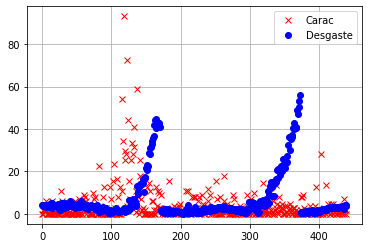

In [10]:
# Vizualizando a Falha 35 desgaste e caracteristica
desgaste = f35_treino.VLR_DESG.values
carac = f35_treino.VLR_CARAC.values
plt.plot(carac,'xr',label='Carac')
plt.plot(desgaste,'ob',label='Desgaste')
plt.legend()
plt.grid()
#plt.savefig("img.pdf")


### Preparação dos dados para treino do modelo

* Identificação quebras na série
* Divisão da série em trechos úteis 
* Janelamento dos trechos em entradas e saídas

In [11]:
def xyfunc (desgaste):
  trechos = []
  for i in range(0,len(desgaste)-1):
    if desgaste[i]-desgaste[i+1]>10:
      trechos.append(desgaste[i-30:i])
      
  trechos.append(desgaste[-30:])
  trechos = np.array(trechos)
  trechos.shape
  x = trechos[:,0:20]
  y = trechos[:,-1]
  return x, y

In [12]:
desgaste_train = f35_treino.VLR_DESG.values
x_train, y_train = xyfunc(desgaste_train)

desgaste_test = f35_teste.VLR_DESG.values
x_test, y_test = xyfunc(desgaste_test)

### Avaliação de modelos

#### MLP

In [13]:
#MLPRegressor
from sklearn.neural_network import MLPRegressor

MLP = MLPRegressor()

MLP.fit(x_train,y_train)
y_pred = MLP.predict(x_test)


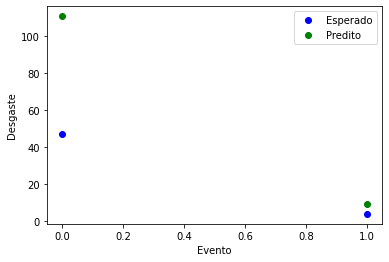

In [14]:
plt.plot(y_test, "ob", label = "Esperado")
plt.plot(y_pred, "og", label = "Predito")
plt.xlabel("Evento")
plt.ylabel("Desgaste")
plt.legend()

#### SVM

#### RNN

In [15]:
x_train = np.reshape(x_train, (x_train.shape[0],1, x_train[0].shape[0])) #reshape para treinar os modelos recorrentes
x_test = np.reshape(x_test, (x_test.shape[0],1, x_test[0].shape[0])) #reshape para treinar os modelos recorrentes
print(x_train.shape, y_train.shape)

(3, 1, 20) (3,)


In [16]:
from tensorflow.keras.layers import SimpleRNN as RNN
# from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(RNN(5, input_shape=(1,20)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, verbose=0)

y_pred = model.predict(x_test)

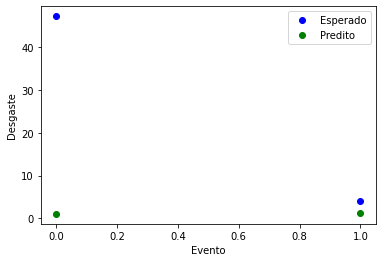

In [17]:
plt.plot(y_test, "ob", label = "Esperado")
plt.plot(y_pred, "og", label = "Predito")
plt.xlabel("Evento")
plt.ylabel("Desgaste")
plt.legend()

## Projeto piloto com oito aeronaves

In [18]:
def xyfunc1 (desgaste,look_back):
  trechos = []
  n_pontos = look_back+10
  a=0
  for i in range(0,len(desgaste)-1):
    if desgaste[i]-desgaste[i+1]>10:
      if i>=n_pontos: 
        trechos.append(desgaste[i-n_pontos:i])
        a = i
  if len(desgaste)-a>=n_pontos:       
    trechos.append(desgaste[-n_pontos:])
  trechos = np.array(trechos)
  print(trechos.shape)
  x = trechos[:,0:20]
  y = trechos[:,-1]
  return x, y

In [34]:
def xyfunc (desgaste,look_back):
  trechos = []
  n_pontos = look_back+10
  a=0
  for i in range(0,len(desgaste)-1):
    if desgaste[i]-desgaste[i+1]>10:
      if len(desgaste[a:i])>n_pontos:
        trechos.append(desgaste[i-n_pontos:i])
        #print(a)
      a = i
  if len(desgaste[a:])>n_pontos:
    trechos.append(desgaste[-n_pontos:])
    #print(a)
  trechos = np.array(trechos)
  #print(trechos.shape)
  x = trechos[:,0:20]
  y = trechos[:,-1]
  return x, y

In [32]:
def func_plot (desgaste,aeronave):
  plt.figure(figsize=(9, 3),dpi=300)
  #plt.plot(carac,'xr',label='Carac')
  plt.plot(desgaste,'ob',label='Desgaste', markersize=2)
  plt.legend()
  plt.title(aeronave)
  plt.grid()
  plt.ylim([0,100])

In [19]:
cod_falha = 35
aeronaves = np.unique(data.COD_AENV)
for aeronave in aeronaves[0:1]:
  f_treino = data[(data.COD_AENV!=aeronave) & (data.COD_FALH==cod_falha)]
  f_teste = data[(data.COD_AENV==aeronave)  & (data.COD_FALH==cod_falha)]
  print(f_treino.shape,f_teste.shape)



(3014, 8) (440, 8)


In [51]:
aeronave_test = 1011 #opções: 1011, 9486, 9526, 9636, 9664, 9678, 9770, 9793
x_train = -1
y_train = -1
for aeronave in aeronaves:
  aero_data = data[(data.COD_AENV==aeronave)  & (data.COD_FALH==cod_falha)]
  desgaste = aero_data.VLR_DESG.values
  #func_plot (desgaste,aeronave)
  x, y = xyfunc(desgaste,look_back=20)
  # desgaste_test = f35_teste.VLR_DESG.values
  if aeronave == aeronave_test:
    x_test, y_test = x, y
  else:
    if np.sum(x_train) == -1 :
      x_train = x
      y_train = y
    else:
      x_train = np.concatenate((x_train,x),axis=0)
      y_train = np.concatenate((y_train,y),axis=0)

In [56]:
x_train.shape

(22, 20)

In [57]:
#MLPRegressor
from sklearn.neural_network import MLPRegressor

MLP = MLPRegressor()

MLP.fit(x_train,y_train)
y_pred = MLP.predict(x_test)


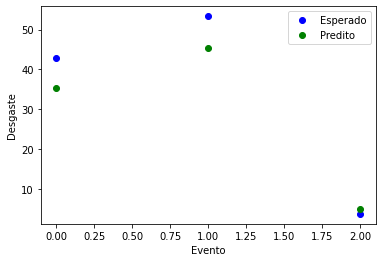

In [58]:
plt.plot(y_test, "ob", label = "Esperado")
plt.plot(y_pred, "og", label = "Predito")
plt.xlabel("Evento")
plt.ylabel("Desgaste")
plt.legend()